<a href="https://colab.research.google.com/github/muvision/CNN-v2/blob/main/CNN_model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [71]:
# Import dependencies

!pip install opendatasets
!pip install pandas
!pip install kaggle
!pip install unrar
!pip install patool
import tensorflow as tf
import opendatasets as od
import pandas as pd
import numpy as np
import cv2 as cv
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import patoolib
from PIL import Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.4 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [68]:
# Initialize paths
data_dir = os.path.join(os.curdir, 'extracted_images')
model_dir = os.path.join(os.curdir, 'drive', 'MyDrive', 'Muvision', 'models')

custom_model_path = os.path.join(model_dir, 'custom_model.h5')
resnet_model_path = os.path.join(model_dir, 'resnet_model.h5')
vgg19_model_path = os.path.join(model_dir, 'vgg19_model.h5')
mobilenet_model_path = os.path.join(model_dir, 'mobilenet_model.h5')
ensemble_model_path = os.path.join(model_dir, 'ensemble_model.h5')

In [69]:
# Initialize important variables
classes = 82
input_shape=(45,45,3)
batch_size = 8
image_size = (45, 45)

## Download and unpack dataset from Kaggle

In [72]:
# Download the dataset from kaggle
od.download('https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols', force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jonathanpolina
Your Kaggle Key: ··········


100%|██████████| 343M/343M [00:02<00:00, 158MB/s]


In [76]:
# Unrar the data.rar file we got from Kaggle which contains the data
rar_path = os.path.join(os.curdir, 'handwrittenmathsymbols', 'data.rar')
out_path = os.path.join(os.curdir, 'handwrittenmathsymbols')
patoolib.extract_archive(rar_path)

patool: Extracting ./handwrittenmathsymbols/data.rar ...
patool: running /usr/bin/unrar x -- /content/handwrittenmathsymbols/data.rar
patool:     with cwd='./Unpack_wz57mgwh'
patool: ... ./handwrittenmathsymbols/data.rar extracted to `data' (local file exists).


'data'

## Preprocess the colors


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
(45, 45)


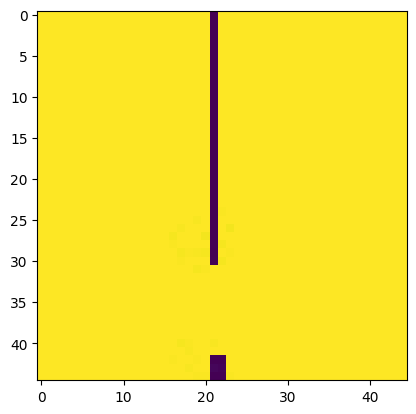

In [ ]:
# Let's see what an individual image in the dataset looks like.
sample_img_path = os.path.join(data_dir, '!', '!_100071.jpg')
img = np.asarray(Image.open(sample_img_path))
imgplot = plt.imshow(img)
print(repr(img))
print(img.shape)

In [ ]:
# Since the images are already gray scale, we don't need to make any changes.

## Preprocess data set

In [ ]:
data_set = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = batch_size, image_size = image_size)

Found 375974 files belonging to 82 classes.


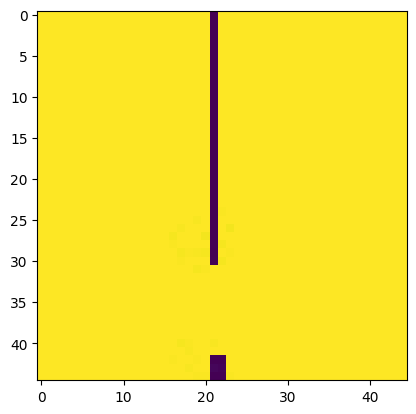

In [ ]:
# We can check if the images need to be normalized by looking at any image.
img = np.asarray(Image.open(sample_img_path))
imgplot = plt.imshow(img)
print(repr(img))

In [ ]:
# Normalize images
data_set = data_set.map(lambda x,y: (x/255, y))

In [ ]:
# Allocate training, validation, and test sizes
train_size = int(len(data_set)* .7)
val_size = int(len(data_set)*.2)+1
test_size = int(len(data_set)*.1)+1

In [ ]:
# Split up dataset into train, validation and test
train = data_set.take(train_size)
val = data_set.skip(train_size).take(val_size)
test = data_set.skip(train_size + val_size).take(test_size)

## Create Custom Model using Tensorflow

In [ ]:
custom_model = models.Sequential(name='Custom_Model')

# Convolutional base
custom_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense layers
custom_model.add(layers.Flatten())
custom_model.add(layers.Dense(64, activation='relu'))
custom_model.add(layers.Dense(classes, activation='softmax'))
custom_model.summary()

# The summary shows that the convolutional base has a (4, 4, 64) output, which
#   is flattened into a (1024) shaped vector, and then sent through two Dense
#   layers

custom_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

custom_model_history = custom_model.fit(train, epochs=10,
                         validation_data=val)

custom_model.save(custom_model_path)

Model: "Custom_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 43, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

2023-06-30 09:52:59.623123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [375974]
	 [[{{node Placeholder/_4}}]]
2023-06-30 09:52:59.624197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [375974]
	 [[{{node Placeholder/_0}}]]


32896/32897 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.8800

2023-06-30 10:02:04.324733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [375974]
	 [[{{node Placeholder/_4}}]]
2023-06-30 10:02:04.325193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [375974]
	 [[{{node Placeholder/_4}}]]


4700/4700 - 63s - loss: 0.1553 - accuracy: 0.9588 - 63s/epoch - 13ms/step


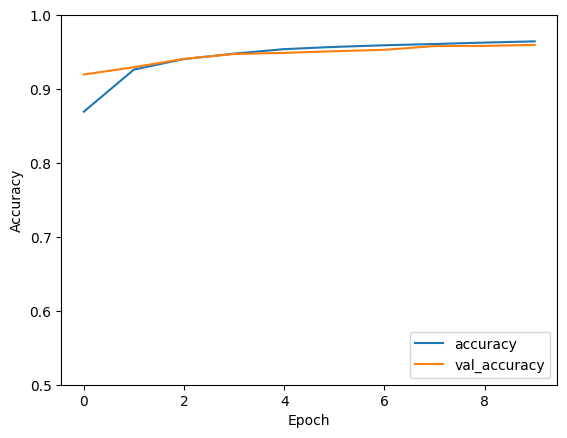

In [ ]:
plt.plot(custom_model_history.history['accuracy'], label='accuracy')
plt.plot(custom_model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = custom_model.evaluate(test, verbose=2)

## Create Model using Resnet-50

In [ ]:
resnet_model = models.Sequential(name='Resnet_Model')

resnet_pretrained_model= tf.keras.applications.ResNet50(include_top=False,

                   input_shape=input_shape,

                   pooling='max',classes=classes,

                   weights='imagenet')

for each_layer in resnet_pretrained_model.layers:

        each_layer.trainable=False

resnet_model.add(resnet_pretrained_model)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.add(layers.Flatten())

resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(classes, activation='softmax'))

In [ ]:
resnet_model.compile(optimizer = optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

epochs = 10
history = resnet_model.fit(train, validation_data=val, epochs=epochs)
resnet_model.save(resnet_model_path)

Epoch 1/10
32897/32897 [==============================] - 3113s 95ms/step - loss: 0.8000 - accuracy: 0.7760 - val_loss: 0.5947 - val_accuracy: 0.8308
Epoch 2/10
32897/32897 [==============================] - 3043s 92ms/step - loss: 0.5746 - accuracy: 0.8346 - val_loss: 0.5922 - val_accuracy: 0.8268
Epoch 3/10
32897/32897 [==============================] - 3101s 94ms/step - loss: 0.5251 - accuracy: 0.8482 - val_loss: 0.5118 - val_accuracy: 0.8543
Epoch 4/10
32897/32897 [==============================] - 3071s 93ms/step - loss: 0.4953 - accuracy: 0.8572 - val_loss: 0.4424 - val_accuracy: 0.8713
Epoch 5/10
32897/32897 [==============================] - 3098s 94ms/step - loss: 0.4773 - accuracy: 0.8621 - val_loss: 0.4651 - val_accuracy: 0.8675
Epoch 6/10
32897/32897 [==============================] - 3105s 94ms/step - loss: 0.4644 - accuracy: 0.8664 - val_loss: 0.5090 - val_accuracy: 0.8536
Epoch 7/10
32897/32897 [==============================] - 3113s 95ms/step - loss: 0.4541 - accuracy:

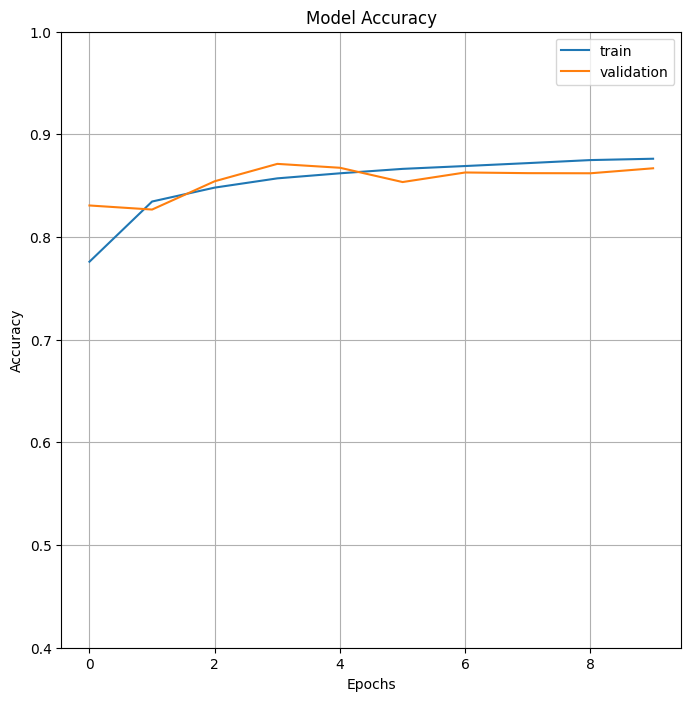

In [ ]:
plt.figure(figsize=(8, 8))

epochs_range= range(epochs)

plt.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")

plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")

plt.axis(ymin=0.4,ymax=1)

plt.grid()

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend(['train', 'validation'])

In [ ]:
#plotter_lib.show()

plt.savefig('output-plot.png')

<Figure size 640x480 with 0 Axes>

## Create Model using VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
vgg19_model = models.Sequential(name='VGG19_Model')

vgg19_pretrained_model= tf.keras.applications.VGG19(include_top=False,

                   input_shape=input_shape,

                   pooling='max',classes=classes,

                   weights='imagenet')

for each_layer in vgg19_pretrained_model.layers:
        each_layer.trainable=False

vgg19_model.add(vgg19_pretrained_model)

In [ ]:
vgg19_model.add(layers.Flatten())

vgg19_model.add(layers.Dense(512, activation='relu'))

vgg19_model.add(layers.Dense(classes, activation='softmax'))

In [ ]:
vgg19_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

epochs = 8
try:
  history = vgg19_model.fit(train, validation_data=val, epochs=epochs)
except Exception as e: print(e)

vgg19_model.save(vgg19_model_path)

Epoch 1/8


2023-06-29 14:34:20.365870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [375974]
	 [[{{node Placeholder/_4}}]]
2023-06-29 14:34:20.366878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [375974]
	 [[{{node Placeholder/_4}}]]
/Users/jpolina/anaconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_l

32897/32897 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.8120

2023-06-29 15:45:01.340777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [375974]
	 [[{{node Placeholder/_4}}]]
2023-06-29 15:45:01.341502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [375974]
	 [[{{node Placeholder/_4}}]]


32897/32897 [==============================] - 5568s 169ms/step - loss: 0.6494 - accuracy: 0.8120 - val_loss: 0.4488 - val_accuracy: 0.8648
Epoch 2/8
32897/32897 [==============================] - 4738s 144ms/step - loss: 0.4242 - accuracy: 0.8706 - val_loss: 0.3891 - val_accuracy: 0.8834
Epoch 3/8
32897/32897 [==============================] - 3933s 120ms/step - loss: 0.3648 - accuracy: 0.8875 - val_loss: 0.3729 - val_accuracy: 0.8890
Epoch 4/8
32897/32897 [==============================] - 3517s 107ms/step - loss: 0.3287 - accuracy: 0.8981 - val_loss: 0.3594 - val_accuracy: 0.8907
Epoch 5/8
32897/32897 [==============================] - 3396s 103ms/step - loss: 0.3040 - accuracy: 0.9046 - val_loss: 0.3381 - val_accuracy: 0.9001
Epoch 6/8
32897/32897 [==============================] - 4008s 122ms/step - loss: 0.2840 - accuracy: 0.9110 - val_loss: 0.3171 - val_accuracy: 0.9041
Epoch 7/8
32897/32897 [==============================] - 3416s 104ms/step - loss: 0.2691 - accuracy: 0.9154 - 

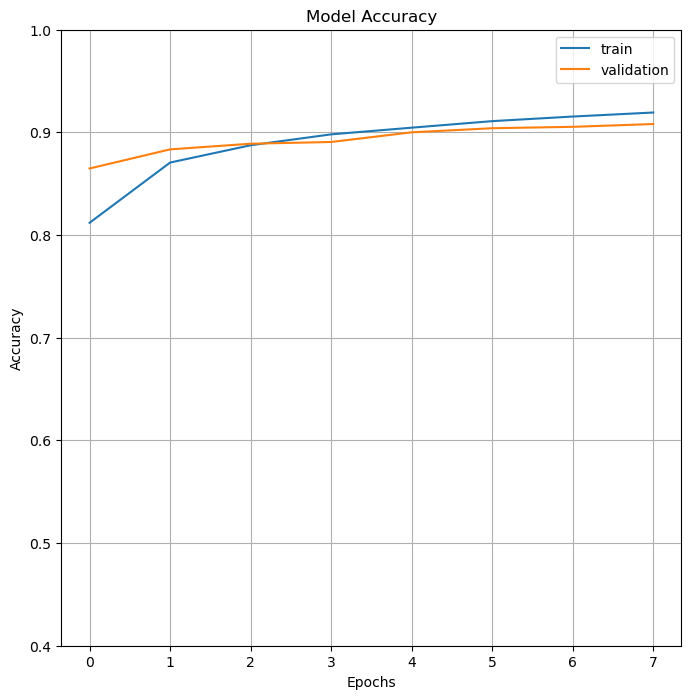

In [ ]:
# Test

plt.figure(figsize=(8, 8))

epochs_range= range(epochs)

plt.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")

plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")

plt.axis(ymin=0.4,ymax=1)

plt.grid()

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend(['train', 'validation'])

## Create Model using MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
mobilenet_model = models.Sequential(name='MobileNet_Model')
mobilenet_pretrained_model = tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=input_shape,
                   pooling='max',classes=classes,
                   weights='imagenet')
for each_layer in mobilenet_pretrained_model.layers:
        each_layer.trainable=False

mobilenet_model.add(mobilenet_pretrained_model)

In [ ]:
mobilenet_model.add(layers.Flatten())

mobilenet_model.add(layers.Dense(512, activation='relu'))

mobilenet_model.add(layers.Dense(classes, activation='softmax'))

In [ ]:
mobilenet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

epochs = 8
try:
  history = mobilenet_model.fit(train, validation_data=val, epochs=epochs)
except Exception as e: print(e)
mobilenet_model.save(mobilenet_model_path)

Epoch 1/8
32897/32897 [==============================] - 1811s 55ms/step - loss: 0.7551 - accuracy: 0.7886 - val_loss: 0.6062 - val_accuracy: 0.8261
Epoch 2/8
32897/32897 [==============================] - 1981s 60ms/step - loss: 0.5175 - accuracy: 0.8521 - val_loss: 0.5097 - val_accuracy: 0.8573
Epoch 3/8
32897/32897 [==============================] - 1997s 61ms/step - loss: 0.4358 - accuracy: 0.8754 - val_loss: 0.4685 - val_accuracy: 0.8759
Epoch 4/8
32897/32897 [==============================] - 4167s 127ms/step - loss: 0.3874 - accuracy: 0.8908 - val_loss: 0.5075 - val_accuracy: 0.8722
Epoch 5/8
32897/32897 [==============================] - 8527s 259ms/step - loss: 0.3506 - accuracy: 0.9015 - val_loss: 0.4425 - val_accuracy: 0.8869
Epoch 6/8
32897/32897 [==============================] - 5875s 179ms/step - loss: 0.3252 - accuracy: 0.9096 - val_loss: 0.4311 - val_accuracy: 0.8927
Epoch 7/8
32897/32897 [==============================] - 4970s 151ms/step - loss: 0.3025 - accuracy: 0.

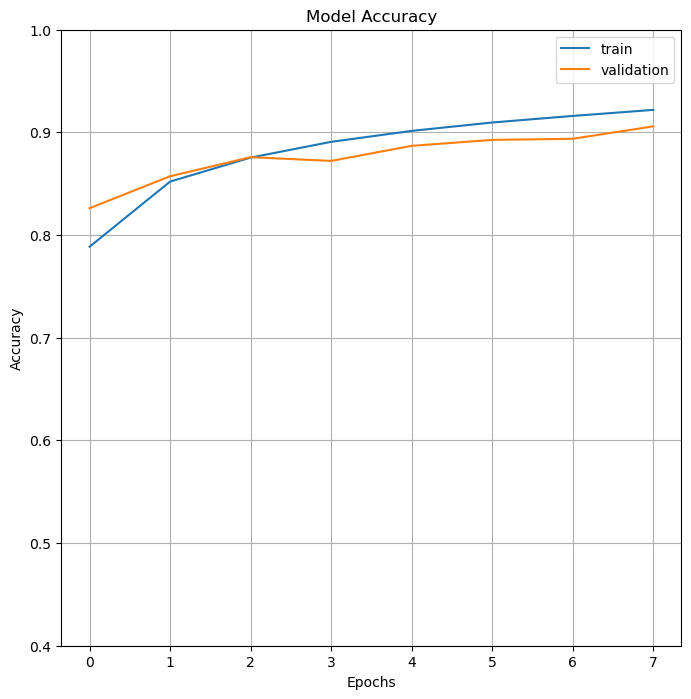

In [ ]:
# Test

plt.figure(figsize=(8, 8))

epochs_range= range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")

plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")

plt.axis(ymin=0.4,ymax=1)

plt.grid()

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend(['train', 'validation'])

## Ensemble

In [ ]:
# Load trained models from file system
models = [models.load_model(custom_model_path),
          models.load_model(resnet_model_path),
          models.load_model(vgg19_model_path),
          models.load_model(mobilenet_model_path)]

In [ ]:
input_shape

(45, 45, 3)

In [ ]:
# Create the weighted average ensemble model
weights = [0.25, 0.25, 0.25, 0.25]
inputs = layers.Input(shape = input_shape)
outputs = [model(inputs) for model in models]
weighted_average = tf.reshape((), (0, classes)) # An empty tensor

for i in range(0, len(models)):
    if i == 0:
        weighted_average = weights[i] * outputs[i]
    else:
        weighted_average = weighted_average + weights[i] * outputs[i]

ensemble_model = tf.keras.Model(inputs = inputs, outputs = weighted_average, name = 'Ensemble_Model')

In [ ]:
ensemble_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['sparse_categorical_accuracy'])
# ensemble_model.compile(optimizer = optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
ensemble_model.save(ensemble_model_path)

In [ ]:
ensemble_model.evaluate(test)

4700/4700 [==============================] - 1880s 386ms/step - loss: 3.5295 - sparse_categorical_accuracy: 0.9748


[3.5295345783233643, 0.9747858643531799]

## Testing

In [ ]:
# Testing the ensemble model

iterator = test.__iter__()
current = iterator.get_next()
plt.imshow(current[0][0])

In [ ]:
ensemble_model_prediction = ensemble_model.predict(current[0])
print(ensemble_model_prediction[0])

In [ ]:
custom_model = tf.keras.models.load_model(custom_model_path)
custom_model_prediction = custom_model.predict(current[0])
print(custom_model_prediction[0])

In [ ]:
resnet_model = tf.keras.models.load_model(resnet_model_path)
resnet_model_prediction = resnet_model.predict(current[0])
print(resnet_model_prediction[0])

In [ ]:
vgg19_model = tf.keras.models.load_model(vgg19_model_path)
vgg19_model_prediction = vgg19_model.predict(current[0])
print(vgg19_model_prediction[0])

In [ ]:
mobilenet_model = tf.keras.models.load_model(mobilenet_model_path)
mobilenet_model_prediction = mobilenet_model.predict(current[0])
print(mobilenet_model_prediction[0])

In [ ]:
custom_model.evaluate(test)

In [ ]:
mobilenet_model.evaluate(test)
resnet_model.evaluate(test)
vgg19_model.evaluate(test)

## Creating a function to classify images

In [113]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from skimage import transform
import cv2 as cv
import keras

ensemble_model_path = os.path.join(os.curdir, 'drive', 'MyDrive', 'Muvision', 'models', 'ensemble_model.h5')
ensemble_model = tf.keras.models.load_model(ensemble_model_path)
image_shape = (45,45,3)

In [114]:
def classify_to_index(filename):
  np_image = np.asarray(Image.open(filename))

  np_image = transform.resize(np_image, input_shape)
  np_image = np.expand_dims(np_image, axis=0)
  prediction = ensemble_model.predict(np_image)
  tensor = tf.math.argmax(prediction[0], axis=None, output_type=tf.dtypes.int64, name=None)
  return int(tensor)

In [115]:
# Put all the classes in the correct order in a list
class_order = [-1]*82
directory = './extracted_images'
ensemble_model_path = os.path.join(os.curdir, 'drive', 'MyDrive', 'Muvision', 'models', 'custom_model.h5')

custom_model = tf.keras.models.load_model(custom_model_path)
for root, dirs, files in os.walk(directory):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        dir_files = os.listdir(dir_path)
        if len(dir_files) > 0:
            first_file = os.path.join(os.curdir, 'extracted_images', dir_name, dir_files[0])
            index = classify_to_index(first_file)
            class_order[index] = dir_name
print(class_order)

1/1 [==============================] - 0s 66ms/step
['!', '(', ')', '+', 'forward_slash', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'q', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', -1, 'T', 'X', '[', ']', 'alpha', -1, 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', -1, 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', -1, 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', -1, 'p', 'phi', 'pi', 'pm', -1, -1, 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', -1, 'u', 'v', 'w', 'y', 'z', '{', '}']


In [120]:
class_order = ['!', '(', ')', '+', 'forward_slash', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
def classify(filename):
  return class_order[classify_to_index(filename)]

In [121]:
# Testing the function on a single image
sample_img_name = os.path.join(os.curdir, 'drive', 'MyDrive', 'Muvision', 'sample_img', ')_15.jpg')
classify(sample_img_name)


1/1 [==============================] - 0s 60ms/step


')'